# Calculate air-sea fluxes
This builds on `cm26_combine_filter_inputs.ipynb`


In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
# !mamba install aerobulk-python -y

In [3]:
import json
import gcsfs
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
import os
import dask

from aerobulk import noskin
from scale_aware_air_sea.utils import maybe_write_to_temp_and_reload,open_zarr, weighted_coarsen
from scale_aware_air_sea.parameters import get_params

In [4]:
# Reproducibility info
os.environ['JUPYTER_IMAGE']

'pangeo/pangeo-notebook:ebeb9dd'

## Failure with newer image versions!
I have experienced some gnarly dependency issues when running this on newer pangeo image version (for example: `2023.05.18`). There is an error that states that dependencies between client and workers are not the same. 
Likely issue is something change in dask? Hard to test this without a custom image (with pinned dask versions). 

TODO: Once the manuscript is submitted I should invest some time to figure out exactly what is going on. 
[Manual image options for the hub](https://github.com/jupyterhub/kubespawner/pull/735) will help a lot here, so I should wait for that.

In [5]:
import subprocess
import logging
from distributed import WorkerPlugin

class MambaPlugin(WorkerPlugin):
    """
    Install packages on a worker as it starts up.

    Parameters
    ----------
    packages : List[str]
        A list of packages to install with pip on startup.
    """
    def __init__(self, packages):
        self.packages = packages

    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['mamba', 'install'] + self.packages)
        logger.info("Installed %s", self.packages)

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
# really unsure how to get the most out of our n2 node allowance here
# Should I go for 'full' utilization of each node with large workers?

options.worker_memory = 115 # Have been able to get 115 so far.
options.worker_cores = 15 # somehow I can not get all 16 cores here....  Need to understand these limits and how to split up a node properly.


# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()

plugin = MambaPlugin(['aerobulk-python'])
client.register_worker_plugin(plugin)
# cluster.scale(50)
cluster.adapt(1,30)
client

### debugging attempt
# from distributed import CondaInstall
# plugin = CondaInstall(packages=["scikit-learn"], conda_options=["--update-deps"])

# from distributed import LocalCluster, Client
# cluster = LocalCluster(n_workers=4, threads_per_worker=2)
# client = Client(cluster)
# client

[ClusterReport<name=prod.bbf6cb530dfc41499ac9f6f43e737cb2, status=RUNNING>]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.d6b260c1fb5c4bbe882147e8716a37d7/status,


In [6]:
def check_version():
    import aerobulk, dask, distributed
    return aerobulk.__version__,dask.__version__, distributed.__version__

client.run(check_version)

{}

In [7]:
def compute_fluxes(
    ds,
    algo,
    method,
    sst_name = 'surface_temp',
    t_name = 't_ref',
    q_name = 'q_ref',
    u_name = 'u_relative',
    v_name = 'v_relative',
    slp_name = 'slp',
    skin_correction = False
):
    ds = ds.copy() # TODO: Does this help with inplace modification? If so, why?
    # input dependent on method
    # FIXME: Technically we should probably make the 'filtered' suffix optional, since this could also be coarseened?
    if method == 'smooth_tracer':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_vel':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered']
        v = ds[v_name+'_filtered']
        slp = ds[slp_name]
    elif method == 'smooth_vel_tracer_atmos':
        sst = ds[sst_name]
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name+'_filtered_atmos_only']
        v = ds[v_name+'_filtered_atmos_only']
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_vel_tracer_ocean':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered_ocean_only']
        v = ds[v_name+'_filtered_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_vel_ocean':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered_ocean_only']
        v = ds[v_name+'_filtered_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_all':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name+'_filtered']
        v = ds[v_name+'_filtered']
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_none':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name]
    else:
        raise ValueError(f'`method`{method} not recognized')
        
    # if skin_correction:
    #     func = noskin
    
    ## test ranges on first timestep
    noskin(
        sst.isel(time=0),
        t.isel(time=0),
        q.isel(time=0),
        u.isel(time=0),
        v.isel(time=0),
        slp=slp.isel(time=0),
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=True
    )
    
    
    ds_out = xr.Dataset()
    (
        ds_out['ql'],
        ds_out['qh'],
        ds_out['taux'],
        ds_out['tauy'],
        ds_out['evap']
    ) =  noskin(
        sst,
        t,
        q,
        u,
        v,
        slp=slp,
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=False
    )
    return ds_out


def _concat_flux_methods(ds, algo, smoothing_methods, skin_correction):
    algo_datasets = []
    for method in smoothing_methods:
        ds_method = compute_fluxes(ds, algo, method, skin_correction=skin_correction)
        ds_method = ds_method.assign_coords(smoothing=method)
        algo_datasets.append(ds_method)

    ds_algo = xr.concat(algo_datasets, dim='smoothing')
    ds_algo = ds_algo.assign_coords({'algo':f"{algo}{'_'+skin if skin_correction else ''}"})
    return ds_algo
    

def flux_compute_wrapper_filter(ds:xr.Dataset, algo_options:list[str, bool], smoothing_methods: list[str], ice_mask:xr.DataArray) -> xr.Dataset:
    """Wrapper to apply the flux computation for different algorithms and smoothed fields
    
    """
    datasets = []
    for algo, skin_correction in algo_options:
        ds_algo = _concat_flux_methods(ds, algo, smoothing_methods, skin_correction)
        datasets.append(ds_algo)
    ds_out = xr.concat(datasets, dim='algo')
    
    # mask with ice_mask
    # Ice mask needs to be applied after, because tempo-spatially variable nans lead to problems with the flux calculation
    ds_out = ds_out.where(ice_mask)
    return ds_out

In [8]:
algo_options_prod = [
    ('ecmwf', False), 
]

algo_options_appendix = [
    ('ncar', False), 
    ('ecmwf', False), 
    ('coare3p0', False), 
    ('coare3p6', False), 
    ('andreas', False)
]

smoothing_methods_prod = [
    'smooth_none',
    'smooth_vel_tracer_ocean',
    'smooth_vel_tracer_atmos',
    'smooth_all'
]

smoothing_methods_appendix = [
    'smooth_none',
    'smooth_tracer',
    'smooth_vel',
    'smooth_vel_tracer_ocean',
    'smooth_vel_tracer_atmos',
    'smooth_all'
]

appendix_time = slice('0181', '0182') # 2 years to match CESM? We could make this a bit longer I guess...

In [9]:
fs = gcsfs.GCSFileSystem()

# load global parameters
params = get_params('v1.0.0', test=False) 


path_temp = params['paths']['CM26']['scratch']
path_filter_fluxes_prod = params['paths']['CM26']['filter_fluxes_prod']
path_filter_fluxes_appendix = params['paths']['CM26']['filter_fluxes_appendix']
path_coarse_fluxes_prod = params['paths']['CM26']['coarse_fluxes_prod']
path_coarse_fluxes_appendix = params['paths']['CM26']['coarse_fluxes_appendix']

ds_filter = open_zarr(params['paths']['CM26']['filter'])
ds_coarse = open_zarr(params['paths']['CM26']['coarse'])

#FIXME: The ice mask needs to be fully reproduced
# ds_ice = open_zarr(params['paths']['CM26']['ice_mask'])
ds_ice = open_zarr('gs://leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/ice_mask_CM26_v0.7.0.zarr')
ice_mask = abs(ds_ice.melt.reset_coords(drop=True)) == 0

In [10]:
# # kill the temp store to trigger rewrite
# fs.rm(path_temp, recursive=True)

In [11]:
ds_original = maybe_write_to_temp_and_reload(fs,path_temp, params['version'])

In [12]:
# # Check that the temp data is fully written (takes long)
# ds_original.isel(time=0).load().to_array().plot(col='variable', col_wrap=4, vmax=0.001)
# ds_original.isel(time=-1).load().to_array().plot(col='variable', col_wrap=4, vmax=0.001)

In [13]:
ds_filter = xr.merge([ds_filter, ds_original], join='override')

## Apply computation on smoothed_data

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
 

<xarray.Dataset>
Dimensions:    (algo: 1, smoothing: 4, time: 7305, yt_ocean: 2700,
                xt_ocean: 3600)
Coordinates: (12/13)
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...         ...
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * smoothing  (smoothing) <U23 'smooth_none' ... 'smooth_all'
  * algo       (algo) <U5 'ecmwf'
Data variables:
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

<xarray.Dataset>
Dimensions:    (algo: 5, smoothing: 6, time: 730, yt_ocean: 2700, xt_ocean: 3600)
Coordinates: (12/13)
  * time       (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...         ...
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

<Figure size 640x480 with 0 Axes>

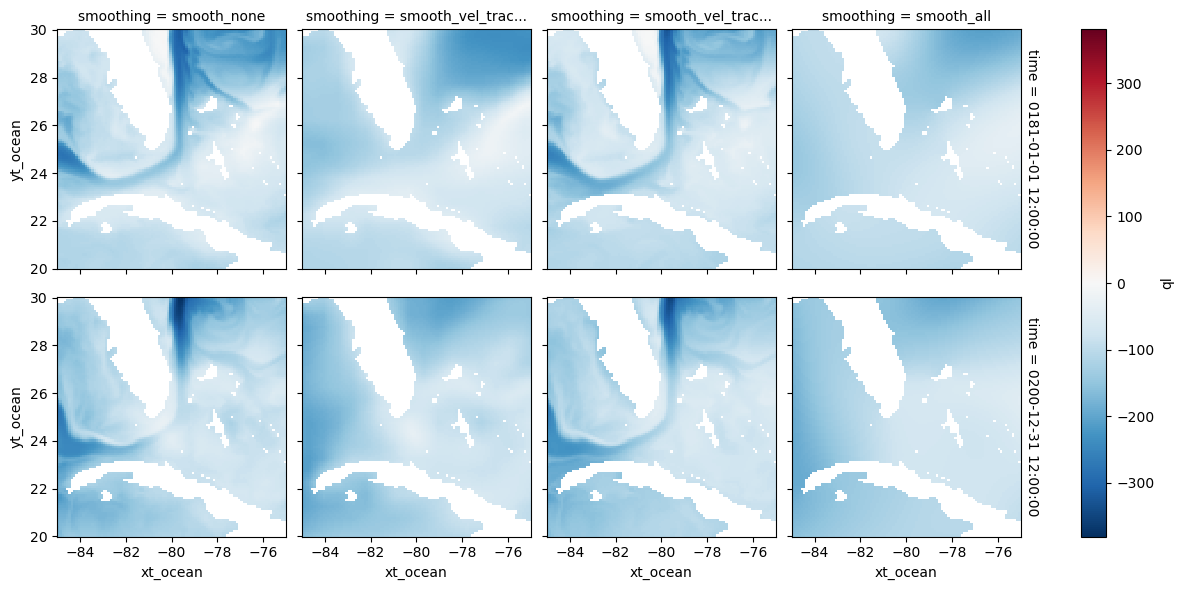

<Figure size 640x480 with 0 Axes>

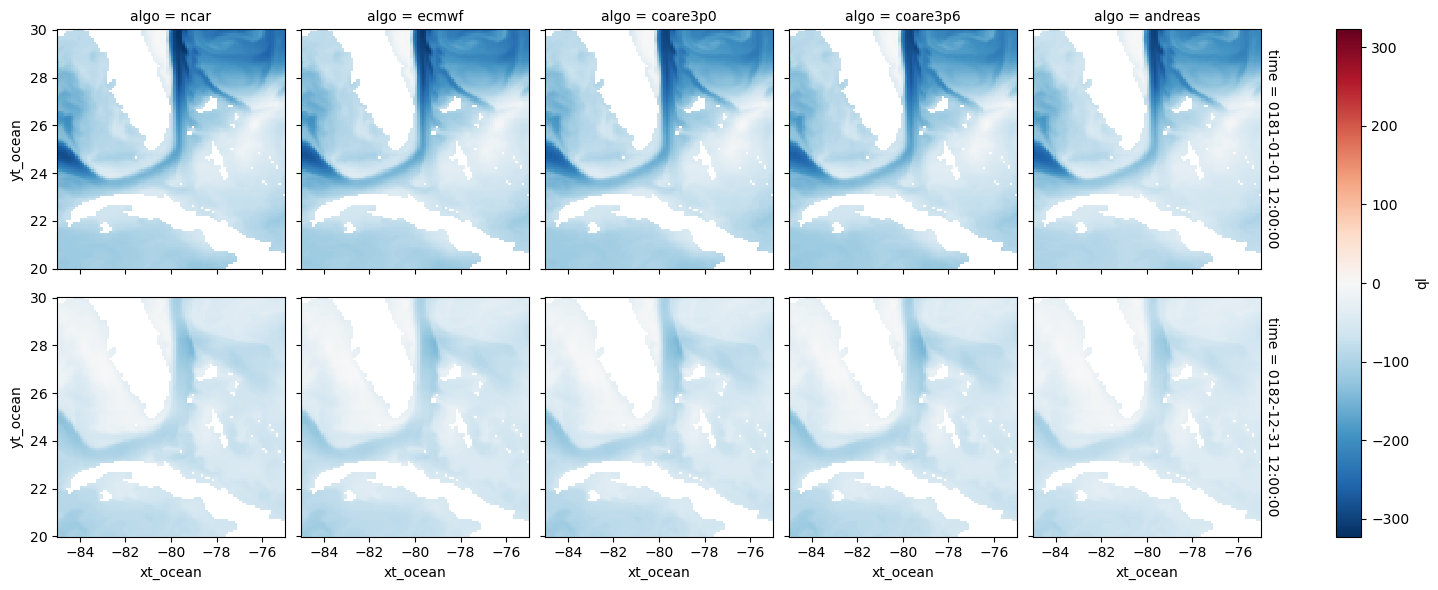

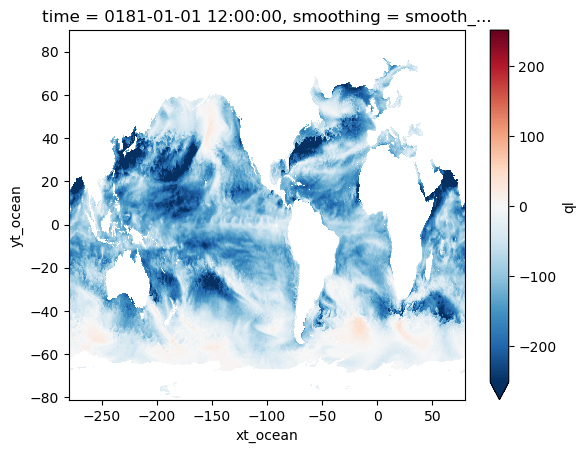

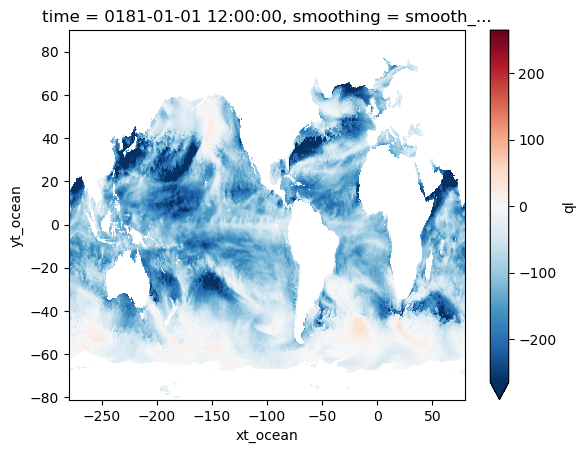

In [ ]:
# in the prod dataset we do not need the extra output
ds_filter_fluxes_prod = flux_compute_wrapper_filter(
    ds_filter,
    algo_options_prod,
    smoothing_methods_prod,
    ice_mask
)[['qh', 'ql']]

ds_filter_fluxes_appendix = flux_compute_wrapper_filter(
    ds_filter.sel(time=appendix_time),
    algo_options_appendix,
    smoothing_methods_appendix,
    ice_mask
)[['qh', 'ql']]

## Verify the output
display(ds_filter_fluxes_prod)
display(ds_filter_fluxes_appendix)

roi = dict(xt_ocean=slice(-85, -75), yt_ocean=slice(20,30))

test_prod = ds_filter_fluxes_prod.ql.isel(time=[0, -1]).sel(**roi).load()
test_appendix = ds_filter_fluxes_appendix.ql.isel(time=[0, -1]).sel(smoothing='smooth_none').sel(**roi).load()

plt.figure()
test_prod.plot(row='time', col='smoothing')

plt.figure()
test_appendix.plot(row='time', col='algo')

# make sure that the icea mask is applied
plt.figure()
ds_filter_fluxes_prod.isel(time=0, algo=0, smoothing=0).ql.plot(robust=True)

plt.figure()
ds_filter_fluxes_appendix.isel(time=0, algo=0, smoothing=0).ql.plot(robust=True)

## Save out data

### Save smoothed data

In [ ]:
ds_filter_fluxes_prod.to_zarr(path_filter_fluxes_prod, mode='w')

In [ ]:
ds_filter_fluxes_appendix.to_zarr(path_filter_fluxes_appendix, mode='w')

In [14]:
# reload the smoothed flux data and plot some test stuff
ds_reload_filter_fluxes_prod = open_zarr(path_filter_fluxes_prod)
ds_reload_filter_fluxes_appendix = open_zarr(path_filter_fluxes_appendix)
display(ds_reload_filter_fluxes_prod)
display(ds_reload_filter_fluxes_appendix)

<xarray.Dataset>
Dimensions:    (algo: 1, yt_ocean: 2700, xt_ocean: 3600, smoothing: 4,
                time: 7305)
Coordinates: (12/13)
  * algo       (algo) <U5 'ecmwf'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...         ...
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * smoothing  (smoothing) <U23 'smooth_none' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

<xarray.Dataset>
Dimensions:    (algo: 5, yt_ocean: 2700, xt_ocean: 3600, smoothing: 6, time: 730)
Coordinates: (12/13)
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...         ...
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

### Test plots for filtered output

In [ ]:
for ds, title in [(ds_reload_filter_fluxes_prod, 'production'),(ds_reload_filter_fluxes_appendix, 'appendix')]:
    da_plot = ds.to_array().weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean']).coarsen(time=30, boundary='trim').mean().load()
    da_plot.plot(hue='algo', row='variable', col='smoothing')
    ds.ql.isel(algo=0,time=[0,-1]).plot(col='smoothing', row='time')

## Apply computation on coarsened data (this relies on reloaded smoothed data, specifically the smooth_none method)

In [15]:
def flux_compute_wrapper_coarse(coarsened:xr.Dataset, filtered:xr.Dataset, coarsen_dim_dict:dict[str:int]) -> xr.Dataset:
    datasets = []
    # align both datasets on inner for time
    exclude_dims = set(filtered.dims)-set(['time'])
    filtered, coarsened  = xr.align(filtered, coarsened, join='inner', exclude=exclude_dims)
    
    # make sure the area of the filtered array is masked consistently with the variables (needed for `weighted_coarsen`)
    nanmask = np.isnan(filtered.qh.isel(time=0).drop('time'))
    area_masked = filtered.area_t.where(~nanmask, 0.0)
    filtered = filtered.assign_coords(area_t=area_masked)
    
    # for this dataset we only have two methods
    # 1. The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
    # This needs to be computed over every algo
    # to avoid misalignment, lets capture the algo from the filtered dataset
    # TODO: Once we actually implement the skin_correction, that needs to be somehow extracted from the algo dimension
    # for now hardcode
    skin_correction = False
    iter_algos = filtered.algo.data
    # in case there is only a single algo
    filtered = filtered.squeeze()
    for algo in iter_algos:
        # The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
        ds_coarse_single_algo = compute_fluxes(coarsened, algo, 'smooth_none', skin_correction=skin_correction)
        # FIXME: this naming is not really easy to understand
        # I could rename the coarsened data before? 
        ds_coarse_single_algo = ds_coarse_single_algo.assign_coords(smoothing='smooth_all')
        datasets.append(ds_coarse_single_algo)
    ds_all_coarse = xr.concat(datasets, dim='algo')
    # and the equivalent to smooth none, where we coarsen the full res flux output
    # this is based on the other precomputed data, so all the algos are there already
    
    ds_none_coarse = weighted_coarsen(
        filtered.sel(smoothing='smooth_none'), 
        coarsen_dim_dict,
        'area_t'
    )
    ds_none_coarse = ds_none_coarse.assign_coords(smoothing='smooth_none')

    # Finally concat along the 'smoothing' dimension (FIXME: better naming for this would be nice).
    ds_full_coarse = xr.concat([ds_none_coarse, ds_all_coarse], dim='smoothing', compat='override', coords='minimal')
    return ds_full_coarse

coarsen_dim_dict = {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}
ds_coarse_fluxes_prod = flux_compute_wrapper_coarse(ds_coarse, ds_reload_filter_fluxes_prod, coarsen_dim_dict)[['qh', 'ql']]
ds_coarse_fluxes_appendix = flux_compute_wrapper_coarse(ds_coarse, ds_reload_filter_fluxes_appendix, coarsen_dim_dict)[['qh', 'ql']]
display(ds_coarse_fluxes_prod)
display(ds_coarse_fluxes_appendix)

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
 

<xarray.Dataset>
Dimensions:    (smoothing: 2, time: 7305, yt_ocean: 54, xt_ocean: 72, algo: 1)
Coordinates: (12/13)
  * algo       (algo) int64 0
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    area_t     (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dyt        (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 370.3
    geolat_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 52.3 0.0 0.0 0.0
    ...         ...
    ht         (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean   (xt_ocean) float64 -277.5 -272.5 -267.5 -262.5 ... 67.5 72.5 77.5
  * yt_ocean   (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    dxt        (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    qh         (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 3, 54, 72, 1), meta=np.ndarray>
    ql         (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 3, 54, 72, 1), meta=np.ndarray>

<xarray.Dataset>
Dimensions:    (smoothing: 2, algo: 5, time: 730, yt_ocean: 54, xt_ocean: 72)
Coordinates: (12/13)
  * time       (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
    area_t     (yt_ocean, xt_ocean, algo) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean   (xt_ocean) float64 -277.5 -272.5 -267.5 -262.5 ... 67.5 72.5 77.5
  * yt_ocean   (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    ...         ...
    geolat_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 52.3 0.0 0.0 0.0
    geolon_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht         (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dxt        (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 42, 42), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 42, 42), meta=np.ndarray>

### Test Plots Coarsened

<Figure size 640x480 with 0 Axes>

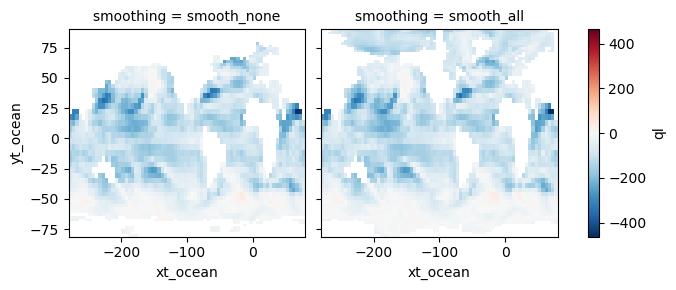

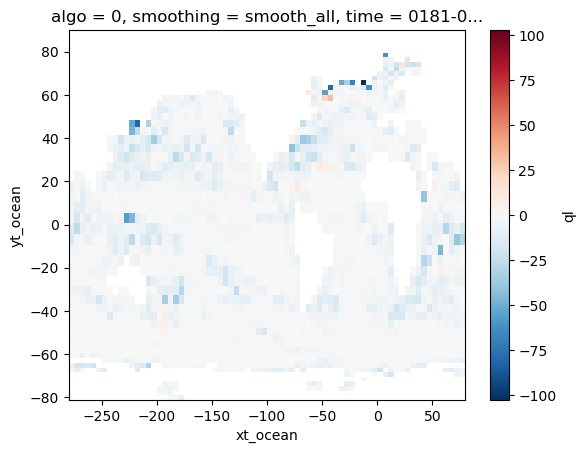

<Figure size 640x480 with 0 Axes>

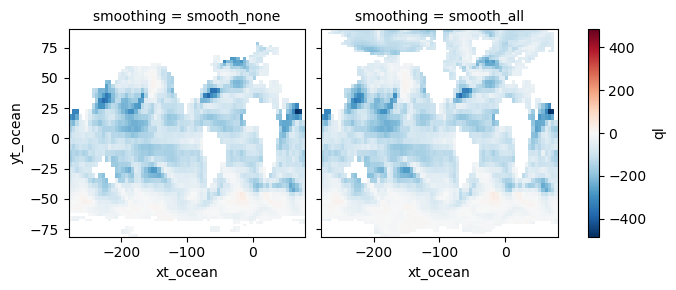

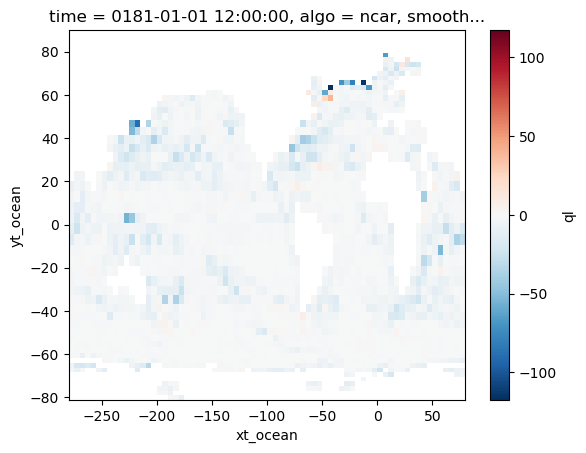

In [16]:
for ds in [ds_coarse_fluxes_prod, ds_coarse_fluxes_appendix]:
    plt.figure()
    ds.ql.isel(time=0, algo=0).plot(col='smoothing')

    plt.figure()
    (-ds.ql.isel(time=0, algo=0).diff('smoothing')).plot()

### Save coarsened data

I was thinking about rechunking the coarse source data, but that might actually cause problems with the one array that is coarsened from the filtered fields. Rechunking here at the end is fine for the resulting data and the overhead is probably small, since the dataset is fairly small at this point.

In [17]:
ds_coarse_fluxes_prod.chunk({'time':370}).to_zarr(path_coarse_fluxes_prod, mode='w')

In [18]:
ds_coarse_fluxes_appendix.chunk({'time':370}).to_zarr(path_coarse_fluxes_appendix, mode='w')

In [19]:
# reload the coarsened flux data
ds_reload_coarse_fluxes_prod = open_zarr(path_coarse_fluxes_prod, chunks={})
ds_reload_coarse_fluxes_appendix = open_zarr(path_coarse_fluxes_appendix, chunks={})

#### Check missing time values

<Figure size 640x480 with 0 Axes>

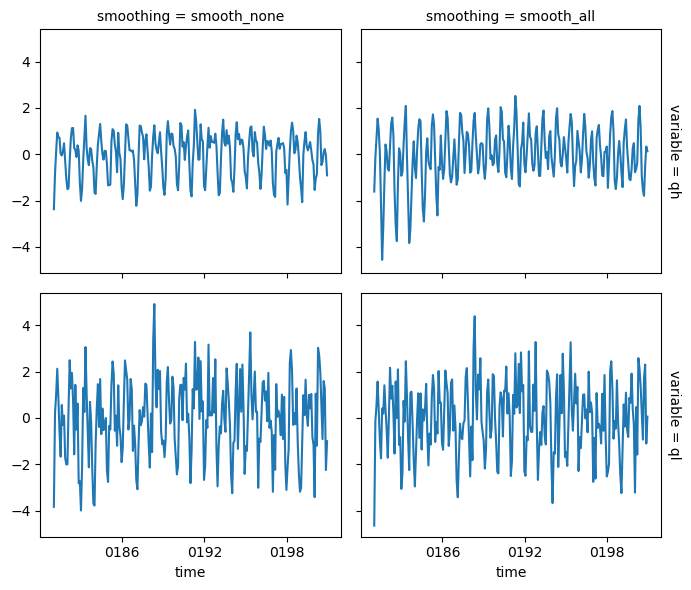

<Figure size 640x480 with 0 Axes>

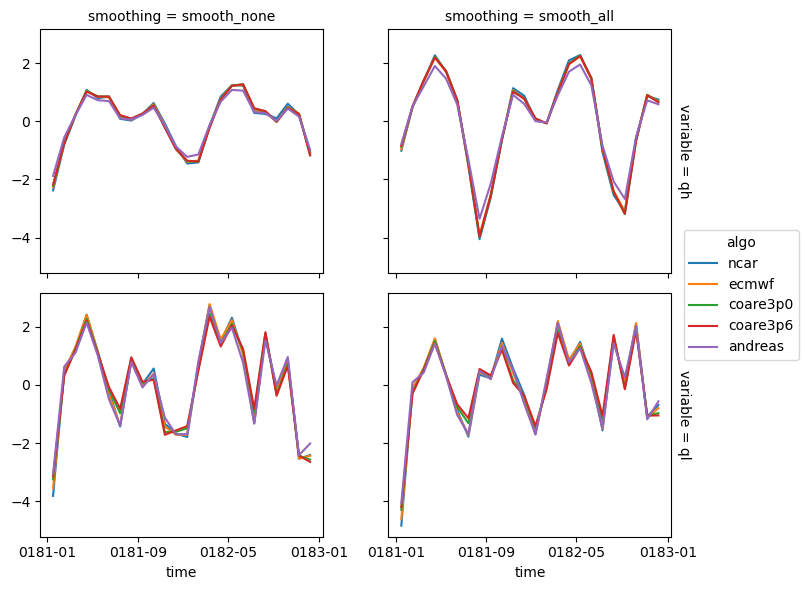

In [21]:
for ds in [ds_reload_coarse_fluxes_prod, ds_reload_coarse_fluxes_appendix]:
    plt.figure()
    da_plot_coarse = ds.weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean']).to_array().load()
    (da_plot_coarse-da_plot_coarse.mean('time')).coarsen(time=30, boundary='trim').mean().plot(hue='algo', col='smoothing', row='variable')

In [22]:
cluster.shutdown()